# Задача

Реализовать класс `MyBinaryLogisticRegression` для работы с логистической регрессией. Обеспечить возможность использования `l1`, `l2` и `l1l2` регуляризации и реализовать слудующие методы решения оптимизационной задачи:

*   Градиентный спуск
*   Стохастический градиентный спуск
*   Метод Ньютона

Обосновать применимость/не применимость того или иного метода оптимизации в случае использованного типа регуляризации.



In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from scipy.special import expit


class MyBinaryLogisticRegression:
    # -- Готово -- 
    def __init__(self, weight_calc='gd', regularization=None, lambda_1=None, lambda_2=None, batch_size=20):

        if weight_calc not in ['gd', 'sgd', 'newton']:
            raise TypeError(f"Параметр weight_calc не может принимать значение: '{weight_calc}'")
        if regularization not in ['l1', 'l2', 'l1l2', None]:
            raise TypeError(f"Параметр regularization не может принимать значение: '{regularization}'")
        if regularization in ['l1', 'l1l2'] and lambda_1 is None:
            raise TypeError(f"Не задано значение параметра регуляризации(lambda_1)")
        if regularization in ['l2', 'l1l2'] and lambda_2 is None:
            raise TypeError(f"Не задано значение параметра регуляризации(lambda_2)")

        self.coefs_ = None
        self.feature_names_in_ = None
        self.weight_calc=weight_calc
        self.regularization=regularization
        self.lambda_1=lambda_1
        self.lambda_2=lambda_2
        self.batch_size=batch_size




    def fit(self, X: pd.DataFrame, y: pd.DataFrame, max_iter=15000, learning_rate=0.000000004, stopping_criteria=0.0001):
        # -- Инициализация весов(с фиксированным зерном рандома) -- 
        np.random.seed(seed=10)
        W = np.random.uniform(size=(X.shape[1]+1))
        num_iter = 0 

        # -- Градиентный спуск -- 
        if self.weight_calc == 'gd':
            X = np.concatenate((np.array(np.ones(len(X)))[:, None], X), axis=1)
            grad = - (2/X.shape[0]) * (np.array(y[0].tolist()) - np.array(list(map(expit, X @ W)))) @ X

            while np.linalg.norm(grad) > stopping_criteria and num_iter < max_iter:
                if self.regularization == None:
                    W -= learning_rate * grad 
                elif self.regularization == 'l1':
                    W -= learning_rate * ( grad + self.lambda_1 * np.sign(W) )
                elif self.regularization == 'l2':
                    W -= learning_rate * ( grad + self.lambda_2 * W )
                else:
                    W -= learning_rate * ( grad + self.lambda_2 * W + self.lambda_1 * np.sign(W) )
                
                grad = - (2/X.shape[0]) * (np.array(y[0].tolist()) - np.array(list(map(expit, X @ W)))) @ X
                num_iter += 1
            

        # -- Стохастический градиентный спуск -- 
        elif self.weight_calc == 'sgd':
            tmp = pd.concat((X, y), axis=1).sample(n=self.batch_size)
            X_st = tmp.drop(columns='species')
            y_st = tmp['species']
            
            X_st = np.concatenate((np.array(np.ones(len(X_st)))[:, None], X_st), axis=1)

            grad_st = - (2/X_st.shape[0]) * (np.array(y_st.tolist()) - np.array(list(map(expit, X_st @ W)))) @ X_st

            while np.linalg.norm(grad_st) > stopping_criteria and num_iter < max_iter:
                if self.regularization == None:
                    W -= learning_rate * grad_st 
                elif self.regularization == 'l1':
                    W -= learning_rate * ( grad_st + self.lambda_1 * np.sign(W) )
                elif self.regularization == 'l2':
                    W -= learning_rate * ( grad_st + self.lambda_2 * W )
                else:
                    W -= learning_rate * ( grad_st + self.lambda_2 * W + self.lambda_1 * np.sign(W) )
                
                grad_st = - (2/X_st.shape[0]) * (np.array(y_st.tolist()) - np.array(list(map(expit, X_st @ W)))) @ X_st
                num_iter += 1


        # -- Метод Ньютона --
        else:
            X = np.concatenate((np.array(np.ones(len(X)))[:, None], X), axis=1)
            hess = X.T @ np.diag(list(map(lambda x: expit(x) * (1 - expit(x)), X @ W))) @ X
            grad = - (2/X.shape[0]) * (np.array(y[0].tolist()) - np.array(list(map(expit, X @ W)))) @ X

            while np.linalg.norm(grad) > stopping_criteria and num_iter < max_iter:
                if self.regularization is None:
                    W -= learning_rate * np.linalg.pinv(hess) @ grad 
                elif self.regularization == 'l1':
                    W -= learning_rate * ( np.linalg.pinv(hess) @ grad + self.lambda_1 * np.sign(W) )
                elif self.regularization == 'l2':
                    W -= learning_rate * ( np.linalg.pinv(hess) @ grad + self.lambda_2 * W )
                else:
                    W -= learning_rate * ( np.linalg.pinv(hess) @ grad + self.lambda_1 * np.sign(W) + self.lambda_2 * W )

                grad = - (2/X.shape[0]) * (np.array(y[0].tolist()) - np.array(list(map(expit, X @ W)))) @ X
                hess = X.T @ np.diag(list(map(lambda x: expit(x) * (1 - expit(x)), X @ W))) @ X
                num_iter += 1 


        # -- Присваиваем объекту класса вектор весов -- 
        self.W = W


    # -- Готово -- 
    def predict(self, X: np.array):
        X = np.concatenate((np.array(np.ones(len(X)))[:, None], X), axis=1)
        data = X @ self.W

        data_min = data.min()
        data_max = data.max()

        data_scaled = 2 * (data - data_min) / (data_max - data_min) - 1
        y_pred = [round(pred) for pred in list(map(expit, X @ self.W))]        
        return y_pred

    # -- Готово -- 
    def score(self, X: np.array, y: np.array):
        return f1_score(y_true=y, y_pred=X)

Продемонстрировать применение реализованного класса на датасете про пингвинов (целевая переменная — вид пингвина). Рассмотреть все возможные варианты (регуляризация/оптимизация). Для категориального признака `island` реализовать самостоятельно преобразование `Target Encoder`, сравнить результаты классификации с `one-hot`. В качестве метрики использовать `f1-score`.

In [167]:
df = pd.read_csv('penguins_binary_classification.csv')


# -- Кодируем тагрет цифрой -- 
df['species'] = df['species'].apply(lambda x: 1 if x == 'Gentoo' else 0)


# -- Делаем TargetEncoding для категориального признака остров -- 
column_codes = df.groupby('island').agg({
    'species': 'mean'
}).reset_index().rename(columns={'species': 'island_coded'})


df = pd.merge(df, column_codes, on='island')
df.drop(columns='island', inplace=True)

df

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,island_coded
0,0,39.1,18.7,181.0,3750.0,2007,0.000000
1,0,39.5,17.4,186.0,3800.0,2007,0.000000
2,0,40.3,18.0,195.0,3250.0,2007,0.000000
3,0,36.7,19.3,193.0,3450.0,2007,0.000000
4,0,39.3,20.6,190.0,3650.0,2007,0.000000
...,...,...,...,...,...,...,...
269,1,47.2,13.7,214.0,4925.0,2009,0.736527
270,1,46.8,14.3,215.0,4850.0,2009,0.736527
271,1,50.4,15.7,222.0,5750.0,2009,0.736527
272,1,45.2,14.8,212.0,5200.0,2009,0.736527


In [168]:
df.shape

(274, 7)

In [222]:
# -- Разделяем на тест и контроль -- 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns='species'), df['species'], test_size=0.33, random_state=42, stratify=df['species'])

In [143]:
# -- Обучаем модель(gd, l1) --
model1 = MyBinaryLogisticRegression(regularization='l1', lambda_1=1)
model1.fit(X_train, y_train)


y_pred1 = model1.predict(X_test)

# -- Чуть лучше чем тыкать наугад -- 
print(model1.score(y_pred1, y_test))

0.5714285714285714


In [ ]:
# -- Обучаем модель (gd, l2) --
model2 = MyBinaryLogisticRegression(regularization='l2', lambda_2=1)
model2.fit(X_train, y_train)


y_pred2 = model2.predict(X_test)

# -- Чуть лучше чем тыкать наугад -- 
print(model2.score(y_pred2, y_test))

0.5826771653543307


In [149]:
# -- Обучаем модель  (gd, l1l2) --
model3 = MyBinaryLogisticRegression(regularization='l1l2', lambda_1=1, lambda_2=1)
model3.fit(X_train, y_train)


y_pred3 = model3.predict(X_test)

# -- Чуть лучше чем тыкать наугад -- 
print(model3.score(y_pred3, y_test))

0.5714285714285714


In [ ]:
# -- Обучаем модель  (sgd, l1) --
model4 = MyBinaryLogisticRegression(weight_calc='sgd', regularization='l1', lambda_1=1, batch_size=20)
model4.fit(X_train, y_train)


y_pred4 = model4.predict(X_test)


print(model4.score(y_pred4, y_test))

0.6212121212121212


In [283]:
# -- Обучаем модель  (sgd, l2) --
model5 = MyBinaryLogisticRegression(weight_calc='sgd', regularization='l2', lambda_2=1, batch_size=20)
model5.fit(X_train, y_train)


y_pred5 = model5.predict(X_test)

 
print(model5.score(y_pred5, y_test))

0.6212121212121212


In [284]:
# -- Обучаем модель  (sgd, l1l2) --
model6 = MyBinaryLogisticRegression(weight_calc='sgd', regularization='l1l2', lambda_1=5, lambda_2=1, batch_size=20)
model6.fit(X_train, y_train)


y_pred6 = model6.predict(X_test)


print(model6.score(y_pred6, y_test))

0.6212121212121212


In [285]:
# -- Обучаем модель  (Newton, l1) --
model7 = MyBinaryLogisticRegression(weight_calc='newton', regularization='l1', lambda_1=1, batch_size=20)
model7.fit(X_train, y_train)


y_pred7 = model7.predict(X_test)


print(model7.score(y_pred7, y_test))

0.6212121212121212


In [286]:
# -- Обучаем модель  (Newton, l2) --
model8 = MyBinaryLogisticRegression(weight_calc='newton', regularization='l2', lambda_2=1, batch_size=20)
model8.fit(X_train, y_train)


y_pred8 = model8.predict(X_test)


print(model8.score(y_pred8, y_test))

0.6212121212121212


In [287]:
# -- Обучаем модель  (Newton, l1l2) --
model9 = MyBinaryLogisticRegression(weight_calc='newton', regularization='l1l2', lambda_1=1, lambda_2=1, batch_size=20)
model9.fit(X_train, y_train)


y_pred9 = model9.predict(X_test)


print(model9.score(y_pred9, y_test))

0.6212121212121212


----
----

# Теоретическая часть

Пусть данные имеют вид
$$
(x_i, y_i), \quad y_i \in \{1, \ldots,M\}, \quad i \in \{1, \ldots, N\},
$$
причем первая координата набора признаков каждого объекта равна $1$.
Используя `softmax`-подход, дискриминативная модель имеет следующий вид
$$
\mathbb P(C_k|x) = \frac{\exp(\omega_k^Tx)}{\sum_i \exp(\omega_i^Tx)}.
$$
Для написания правдоподобия удобно провести `one-hot` кодирование меток класса, сопоставив каждому объекту $x_i$ вектор $\widehat y_i = (y_{11}, \ldots, y_{1M})$ длины $M$, состоящий из нулей и ровно одной единицы ($y_{iy_i} = 1$), отвечающей соответствующему классу. В этом случае правдоподобие имеет вид
$$
\mathbb P(D|\omega) = \prod_{i = 1}^{N}\prod_{j = 1}^M \mathbb P(C_j|x_i)^{y_{ij}}.
$$
Ваша задача: вывести функцию потерь, градиент и гессиан для многоклассовой логистической регрессии. Реализовать матрично. На синтетическом примере продемонстрировать работу алгоритма, построить гиперплоскости, объяснить классификацию

#### Функция потерь

$$ \frac1n \ln \mathbb{P} (D| \omega) = \frac1n \sum\limits_{i=1}^N \sum\limits_{j=1}^M \ln \mathbb{P} (C_j| x_i)^{y_{ij}} = \frac1n \sum\limits_{i=1}^N \sum\limits_{j=1}^M y_{ij} \ln \left( \frac{\exp (\omega_j^T x_i)}{\sum_k \exp (\omega_k^T x_i)} \right)  $$

#### Градиент (для класса l)

$$ \nabla_{\omega_l} \ln \mathbb{P} (D| \omega) =  \sum\limits_{i=1}^N  y_{il} \ln \left( \frac{\exp (\omega_l^T x_i)}{\sum_k \exp (\omega_k^T x_i)} \right)$$


$$ \nabla_{\omega_l} \ln \left( \frac{\exp (\omega_l^T x_i)}{\sum_k \exp (\omega_k^T x_i)} \right) =  \frac{\sum_k \exp (\omega_k^T x_i)}{\exp (\omega_l^T x_i)} \cdot \left( \frac{x_i \cdot \exp (\omega_l^T x_i) \cdot (\sum_k \exp (\omega_k^T x_i)) - x_i \cdot \exp (\omega_l^T x_i) \cdot \exp (\omega_l^T x_i) }{(\sum_k \exp (\omega_k^T x_i))^2} \right) = $$


$$ = x_i \frac{\sum_{k\neq l} \exp (\omega_k^T x_i)}{\sum_k \exp (\omega_k^T x_i)}  = x_i \left( 1 - \frac{\exp (\omega_l^T x_i)}{\sum_k \exp (\omega_k^T x_i)} \right)$$


#### Итого:

$$  \nabla_{\omega_l} \ln \mathbb{P} (D| \omega) = \sum\limits_{i=1}^N  y_{il}  x_i \left( 1 - \frac{\exp (\omega_l^T x_i)}{\sum_k \exp (\omega_k^T x_i)} \right) $$

#### Гессиан для класса l

$$  \nabla_{\omega_l} \nabla_{\omega_l} \ln \mathbb{P} (D| \omega) =  \nabla_{\omega_l} \sum\limits_{i=1}^N  y_{il}  x_i \left( 1 - \frac{\exp (\omega_l^T x_i)}{\sum_k \exp (\omega_k^T x_i)} \right) = - \sum\limits_{i=1}^N  y_{il}  x_i^2 \frac{\exp (\omega_l^T x_i)}{\sum_k \exp (\omega_k^T x_i)} \left( 1- \frac{\exp (\omega_l^T x_i)}{\sum_k \exp (\omega_k^T x_i)} \right)  $$



$$  \nabla_{\omega_j} \nabla_{\omega_l} \ln \mathbb{P} (D| \omega) =  \nabla_{\omega_j} \sum\limits_{i=1}^N  y_{il}  x_i \left( 1 - \frac{\exp (\omega_l^T x_i)}{\sum_k \exp (\omega_k^T x_i)} \right) =  \sum\limits_{i=1}^N  y_{il}  x_i^2 \frac{\exp (\omega_l^T x_i) \exp (\omega_j^T x_i)}{(\sum_k \exp (\omega_k^T x_i))^2}   $$


#### Матричная реализация

In [123]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score


class MySoftMaxRegression:
    def __init__(self):
        self.coefs_ = None
        self.intercept_vec = None

    def _softmax(self, X, W):
        exp = np.exp(X @ W)

        return exp / np.sum(exp, axis=1, keepdims=1)


    def fit(self, X: pd.DataFrame, y: pd.DataFrame, max_iter=30000, learning_rate=0.00001, stopping_criteria=0.0000001):
        np.random.seed(seed=10)
        num_iter = 0 
        n_samples, n_features = X.shape
        n_classes = y.shape[1]
        
        X = np.hstack((np.ones(X.shape[0])[:, None], X)) 

        # -- W и градиент - теперь матрицы -- 
        W = np.random.uniform(size=(n_features + 1, n_classes))
        matrix_grad = np.zeros((n_features+1, n_classes))
        matrix_softmax = self._softmax(X, W)

        while np.linalg.norm(matrix_grad) > stopping_criteria and num_iter < max_iter:
            for l in range(n_classes):
                for i in range(n_samples):
                    matrix_grad[:, l] += y[i, l] * X[i] * (1 - matrix_softmax[i, l])
            
            W -= learning_rate * matrix_grad * (1/ n_samples)
            matrix_grad = np.zeros((n_features+1, n_classes))
            num_iter += 1

        self.W = W
        self.intercept_vec = W[:, 0]
        self.coefs_ = W[:, 1:]


    def predict(self, X: np.array):
        y_pred = self._softmax(X, self.W)
        max_values = y_pred.max(axis=1, keepdims=True)

        y_pred = (y_pred == max_values).astype(int)
        return y_pred


    def score(self, X: np.array, y: np.array):
        return f1_score(y_true=y, y_pred=self.predict(X), average='weighted')

In [124]:
# -- Синтетические данные -- 
np.random.seed(seed=42)
X1 = np.random.randn(20, 2)
X2 = np.random.rand(20, 2) + [3,3]
X3 = np.random.rand(20, 2) + [5,5]

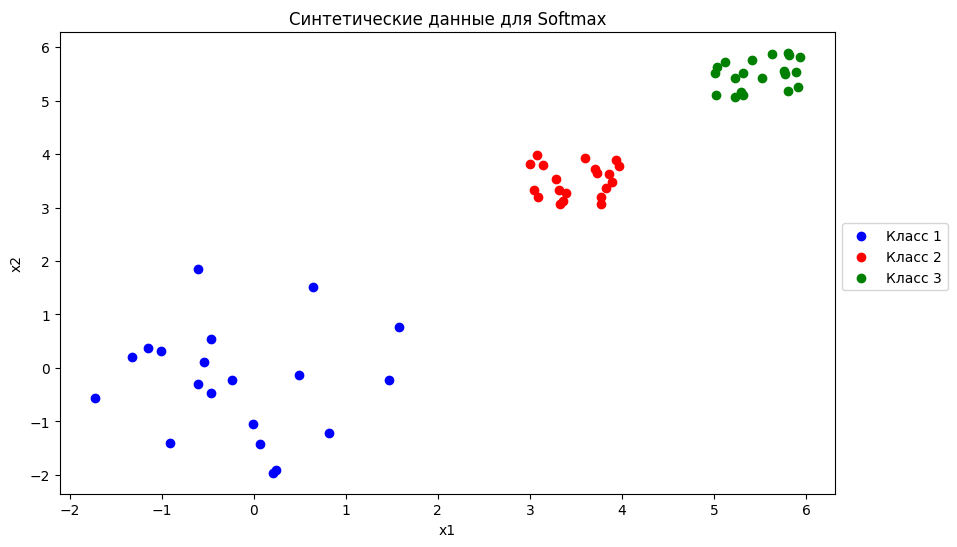

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(X1[:, 0], X1[:, 1], color='blue', label='Класс 1')
plt.scatter(X2[:, 0], X2[:, 1], color='red', label='Класс 2')
plt.scatter(X3[:, 0], X3[:, 1], color='green', label='Класс 3')


plt.legend()
plt.title('Синтетические данные для Softmax')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(bbox_to_anchor=(1, 0.6), loc="upper left")
plt.show()

In [126]:
X1 = pd.DataFrame(X1)
X1['class1'] = 1
X1

X2 = pd.DataFrame(X2)
X2['class2'] = 1
X2

X3 = pd.DataFrame(X3)
X3['class3'] = 1
X3

X = pd.concat([X1, X2, X3], axis=0)
X, y = X.drop(columns=['class1', 'class2', 'class3']), X[['class1', 'class2', 'class3']]

In [134]:
model = MySoftMaxRegression()
model.fit(X, y)

In [135]:
xx = np.linspace(-2, 6)
yy1 = -(model.intercept_vec[0] + xx * model.coefs_[0][0]) / model.coefs_[0][1]
yy2 = -(model.intercept_vec[1] -4 + xx * model.coefs_[1][0]) / model.coefs_[0][1]
yy3 = -(model.intercept_vec[2] -6 + xx * model.coefs_[2][0]) / model.coefs_[0][1]

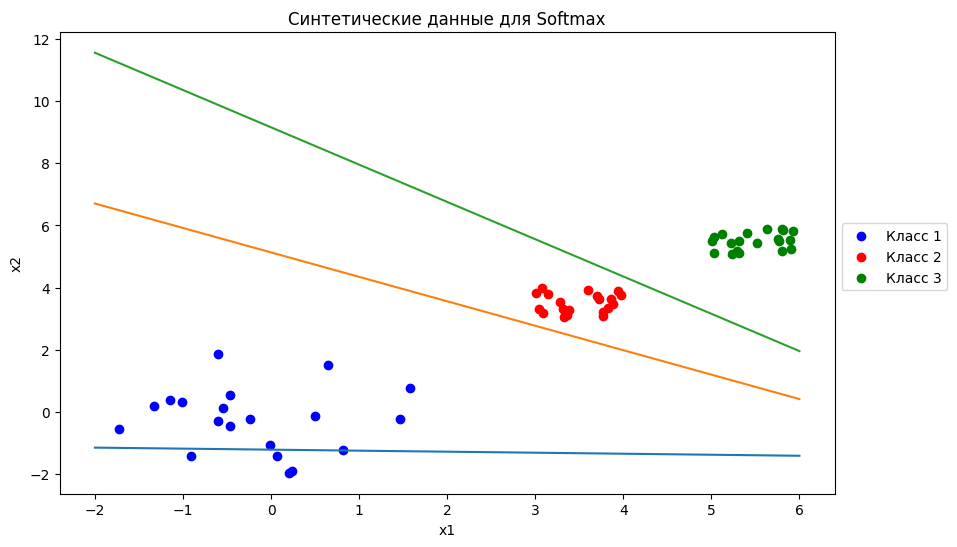

In [136]:
# -- Синтетические данные -- 
np.random.seed(seed=42)
X1 = np.random.randn(20, 2)
X2 = np.random.rand(20, 2) + [3,3]
X3 = np.random.rand(20, 2) + [5,5]

plt.figure(figsize=(10,6))
plt.scatter(X1[:, 0], X1[:, 1], color='blue', label='Класс 1')
plt.scatter(X2[:, 0], X2[:, 1], color='red', label='Класс 2')
plt.scatter(X3[:, 0], X3[:, 1], color='green', label='Класс 3')
plt.plot(xx, yy1)
plt.plot(xx, yy2)
plt.plot(xx, yy3)

plt.legend()
plt.title('Синтетические данные для Softmax')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(bbox_to_anchor=(1, 0.6), loc="upper left")
plt.show()

В целом гиперплоскости для 2 и 3 классов хорошие, т.е. коэффициенты w1 и w2 обучились достаточно, но проблема в свободных членах.

Что касается 1го класса - совсем плохо